In [92]:
import cvxpy as cp
import numpy as np
import math
from queue import PriorityQueue
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.optimize import linprog

In [93]:
# Custom simplex solver that displays tableaus at each step
def simplex_solver_with_steps(c, A, b, bounds):
    """
    Solve LP using simplex method and display full tableau at each step
    
    Parameters:
    - c: Objective coefficients (for maximizing c'x)
    - A: Constraint coefficients matrix
    - b: Right-hand side of constraints
    - bounds: Variable bounds as [(lower_1, upper_1), (lower_2, upper_2), ...]
    
    Returns:
    - x: Optimal solution
    - optimal_value: Optimal objective value
    """
    print("\n--- Starting Simplex Method ---")
    print(f"Objective: Maximize {' + '.join([f'{c[i]}x_{i}' for i in range(len(c))])}")
    print(f"Constraints:")
    for i in range(len(b)):
        constraint_str = ' + '.join([f"{A[i,j]}x_{j}" for j in range(A.shape[1])])
        print(f"  {constraint_str} <= {b[i]}")
    
    # Convert problem to standard form (for tableau method)
    # First handle bounds by adding necessary constraints
    A_with_bounds = A.copy()
    b_with_bounds = b.copy()
    
    for i, (lb, ub) in enumerate(bounds):
        if lb is not None and lb > 0:
            # For variables with lower bounds > 0, we'll substitute x_i = x_i' + lb
            # This affects all constraints where x_i appears
            for j in range(A.shape[0]):
                b_with_bounds[j] -= A[j, i] * lb
    
    # Number of variables and constraints
    n_vars = len(c)
    n_constraints = A.shape[0]
    
    # Add slack variables to create standard form
    # The tableau will have: [objective row | RHS]
    #                        [-------------|----]
    #                        [constraints  | RHS]
    
    # Initial tableau: 
    # First row is -c (negative of objective coefficients) and 0s for slack variables, then 0 (for max)
    # The rest are constraint coefficients, then identity matrix for slack variables, then RHS
    tableau = np.zeros((n_constraints + 1, n_vars + n_constraints + 1))
    
    # Set the objective row (negated for maximization)
    tableau[0, :n_vars] = -c
    
    # Set the constraint coefficients
    tableau[1:, :n_vars] = A_with_bounds
    
    # Set the slack variable coefficients (identity matrix)
    for i in range(n_constraints):
        tableau[i + 1, n_vars + i] = 1
    
    # Set the RHS
    tableau[1:, -1] = b_with_bounds
    
    # Base and non-base variables
    base_vars = list(range(n_vars, n_vars + n_constraints))  # Slack variables are initially basic
    
    # Function to print current tableau
    def print_tableau(tableau, base_vars):
        headers = [f"x_{j}" for j in range(n_vars)] + [f"s_{j}" for j in range(n_constraints)] + ["RHS"]
        rows = []
        row_labels = ["z"] + [f"eq_{i}" for i in range(n_constraints)]
        
        for i, row in enumerate(tableau):
            rows.append([row_labels[i]] + [f"{val:.3f}" for val in row])
        
        print("\nCurrent Tableau:")
        print(tabulate(rows, headers=headers, tablefmt="grid"))
        print(f"Basic variables: {[f'x_{v}' if v < n_vars else f's_{v-n_vars}' for v in base_vars]}")
    
    # Print initial tableau
    print("\nInitial tableau:")
    print_tableau(tableau, base_vars)
    
    # Main simplex loop
    iteration = 0
    max_iterations = 100  # Prevent infinite loops
    
    while iteration < max_iterations:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Find the entering variable (most negative coefficient in objective row for maximization)
        entering_col = np.argmin(tableau[0, :-1])
        if tableau[0, entering_col] >= -1e-10:  # Small negative numbers due to floating-point errors
            print("Optimal solution reached - no negative coefficients in objective row")
            break
        
        print(f"Entering variable: {'x_' + str(entering_col) if entering_col < n_vars else 's_' + str(entering_col - n_vars)}")
        
        # Find the leaving variable using min ratio test
        ratios = []
        for i in range(1, n_constraints + 1):
            if tableau[i, entering_col] <= 0:
                ratios.append(np.inf)  # Avoid division by zero or negative
            else:
                ratios.append(tableau[i, -1] / tableau[i, entering_col])
        
        if all(r == np.inf for r in ratios):
            print("Unbounded solution - no leaving variable found")
            return None, float('inf')  # Problem is unbounded
        
        # Find the row with minimum ratio
        leaving_row = np.argmin(ratios) + 1  # +1 because we skip the objective row
        leaving_var = base_vars[leaving_row - 1]
        
        print(f"Leaving variable: {'x_' + str(leaving_var) if leaving_var < n_vars else 's_' + str(leaving_var - n_vars)}")
        print(f"Pivot element: {tableau[leaving_row, entering_col]:.3f} at row {leaving_row}, column {entering_col}")
        
        # Perform pivot operation
        # First, normalize the pivot row
        pivot = tableau[leaving_row, entering_col]
        tableau[leaving_row] = tableau[leaving_row] / pivot
        
        # Update other rows
        for i in range(tableau.shape[0]):
            if i != leaving_row:
                factor = tableau[i, entering_col]
                tableau[i] = tableau[i] - factor * tableau[leaving_row]
        
        # Update basic variables
        base_vars[leaving_row - 1] = entering_col
        
        # Print updated tableau
        print("\nAfter pivot:")
        print_tableau(tableau, base_vars)
    
    if iteration == max_iterations:
        print("Max iterations reached without convergence")
        return None, None
    
    # Extract solution
    x = np.zeros(n_vars)
    for i, var in enumerate(base_vars):
        if var < n_vars:  # If it's an original variable and not a slack
            x[var] = tableau[i + 1, -1]
    
    # Account for variable substitutions (if lower bounds were applied)
    for i, (lb, _) in enumerate(bounds):
        if lb is not None and lb > 0:
            x[i] += lb
    
    # Calculate objective value
    optimal_value = np.dot(c, x)
    
    print("\n--- Simplex Method Complete ---")
    print(f"Optimal solution found: {x}")
    print(f"Optimal objective value: {optimal_value}")
    
    return x, optimal_value



In [94]:

class BranchAndBoundSolver:
    def __init__(self, c, A, b, integer_vars=None, binary_vars=None, maximize=True):
        """
        Initialize the Branch and Bound solver
        
        Parameters:
        - c: Objective coefficients (for max c'x)
        - A, b: Constraints Ax <= b
        - integer_vars: Indices of variables that must be integers
        - binary_vars: Indices of variables that must be binary (0 or 1)
        - maximize: True for maximization, False for minimization
        """
        self.c = c
        self.A = A
        self.b = b
        self.n = len(c)
        
        # Process binary and integer variables
        self.binary_vars = [] if binary_vars is None else binary_vars
        
        # If integer_vars not specified, assume all non-binary variables are integers
        if integer_vars is None:
            self.integer_vars = list(range(self.n))
        else:
            self.integer_vars = integer_vars.copy()
        
        # Add binary variables to integer variables list if they're not already there
        for idx in self.binary_vars:
            if idx not in self.integer_vars:
                self.integer_vars.append(idx)
        
        # Best solution found so far
        self.best_solution = None
        self.best_objective = float('-inf') if maximize else float('inf')
        self.maximize = maximize
        
        # Track nodes explored
        self.nodes_explored = 0
        
        # Graph for visualization
        self.graph = nx.DiGraph()
        self.node_id = 0
        
        # For tabular display of steps
        self.steps_table = []
        
        # Set of active nodes
        self.active_nodes = set()
    
    def is_integer_feasible(self, x):
        """Check if the solution satisfies integer constraints"""
        if x is None:
            return False
        
        for idx in self.integer_vars:
            if abs(round(x[idx]) - x[idx]) > 1e-6:
                return False
        return True
    
    def get_branching_variable(self, x):
        """Select most fractional variable to branch on"""
        max_fractional = -1
        branching_var = -1
        
        for idx in self.integer_vars:
            fractional_part = abs(x[idx] - round(x[idx]))
            if fractional_part > max_fractional and fractional_part > 1e-6:
                max_fractional = fractional_part
                branching_var = idx
        
        return branching_var
    
    def solve_relaxation(self, lower_bounds, upper_bounds):
        """Solve the continuous relaxation with given bounds"""
        x = cp.Variable(self.n)
        
        # Set the objective - maximize c'x or minimize -c'x
        if self.maximize:
            objective = cp.Maximize(self.c @ x)
        else:
            objective = cp.Minimize(self.c @ x)
        
        # Basic constraints Ax <= b
        constraints = [self.A @ x <= self.b]
        
        # Add bounds
        for i in range(self.n):
            if lower_bounds[i] is not None:
                constraints.append(x[i] >= lower_bounds[i])
            if upper_bounds[i] is not None:
                constraints.append(x[i] <= upper_bounds[i])
        
        prob = cp.Problem(objective, constraints)
        
        try:
            objective_value = prob.solve()
            return x.value, objective_value
        except:
            return None, float('-inf') if self.maximize else float('inf')
    
    def add_node_to_graph(self, node_name, objective_value, x_value, parent=None, branch_var=None, branch_cond=None):
        """Add a node to the branch and bound graph"""
        self.graph.add_node(node_name, obj=objective_value, x=x_value, 
                        branch_var=branch_var, branch_cond=branch_cond)
        
        if parent is not None:
            # Use branch_var + 1 to show 1-indexed variables in the display
            label = f"x_{branch_var + 1} {branch_cond}"
            self.graph.add_edge(parent, node_name, label=label)
        
        return node_name
    
    def visualize_graph(self):
        """Visualize the branch and bound graph"""
        plt.figure(figsize=(20, 8))
        pos = nx.spring_layout(self.graph)  # Use spring layout instead of graphviz

        # Node labels: Node name, Objective value and solution
        labels = {}
        for node, data in self.graph.nodes(data=True):
            if data.get('x') is not None:
                x_str = ', '.join([f"{x:.2f}" for x in data['x']])
                labels[node] = f"{node}\n({data['obj']:.2f}, ({x_str}))"
            else:
                labels[node] = f"{node}\nInfeasible"
        
        # Edge labels: Branching conditions
        edge_labels = nx.get_edge_attributes(self.graph, 'label')
        
        # Draw nodes
        nx.draw_networkx_nodes(self.graph, pos, node_size=2000, node_color='skyblue')
        
        # Draw edges
        nx.draw_networkx_edges(self.graph, pos, width=1.5, arrowsize=20, edge_color='gray')
        
        # Draw labels
        nx.draw_networkx_labels(self.graph, pos, labels, font_size=10, font_family='sans-serif')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=10, font_family='sans-serif')
        
        plt.title("Branch and Bound Tree", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def display_steps_table(self):
        """Display the steps in tabular format"""
        headers = ["Node", "z", "x", "z*", "x*", "UB", "LB", "Z at end of stage"]
        print(tabulate(self.steps_table, headers=headers, tablefmt="grid"))
    
    def solve(self, verbose=True):
        """Solve the problem using branch and bound"""
        # Initialize bounds
        lower_bounds = [0] * self.n
        upper_bounds = [None] * self.n  # None means unbounded
        
        # Set upper bounds for binary variables
        for idx in self.binary_vars:
            upper_bounds[idx] = 1
        
        # Create a priority queue for nodes (max heap for maximization, min heap for minimization)
        # We use negative values for maximization to simulate max heap with Python's min heap
        node_queue = PriorityQueue()
        
        # Solve the root relaxation
        print("Step 1: Solving root relaxation (continuous problem)")
        x_root, obj_root = self.solve_relaxation(lower_bounds, upper_bounds)
        
        if x_root is None:
            print("Root problem infeasible")
            return None, float('-inf') if self.maximize else float('inf')
        
        # Add root node to the graph
        root_node = "S0"
        self.add_node_to_graph(root_node, obj_root, x_root)
        
        print(f"Root relaxation objective: {obj_root:.6f}")
        print(f"Root solution: {x_root}")
        
        # Initial upper bound is the root objective
        upper_bound = obj_root
        
        # Check if the root solution is already integer-feasible
        if self.is_integer_feasible(x_root):
            print("Root solution is integer-feasible! No need for branching.")
            self.best_solution = x_root
            self.best_objective = obj_root
            
            # Add to steps table
            active_nodes_str = "∅" if not self.active_nodes else "{" + ", ".join(self.active_nodes) + "}"
            self.steps_table.append([
                root_node, f"{obj_root:.2f}", f"({', '.join([f'{x:.2f}' for x in x_root])})", 
                f"{self.best_objective:.2f}", f"({', '.join([f'{x:.2f}' for x in self.best_solution])})",
                f"{upper_bound:.2f}", f"{self.best_objective:.2f}", active_nodes_str
            ])
            
            self.display_steps_table()
            self.visualize_graph()
            return x_root, obj_root
        
        # Add root node to the queue and active nodes set
        priority = -obj_root if self.maximize else obj_root
        node_queue.put((priority, self.nodes_explored, root_node, lower_bounds.copy(), upper_bounds.copy()))
        self.active_nodes.add(root_node)
        
        # Add entry to steps table for root node
        active_nodes_str = "{" + ", ".join(self.active_nodes) + "}"
        lb_str = "-" if self.best_objective == float('-inf') else f"{self.best_objective:.2f}"
        x_star_str = "-" if self.best_solution is None else f"({', '.join([f'{x:.2f}' for x in self.best_solution])})"
        
        self.steps_table.append([
            root_node, f"{obj_root:.2f}", f"({', '.join([f'{x:.2f}' for x in x_root])})", 
            lb_str, x_star_str, f"{upper_bound:.2f}", lb_str, active_nodes_str
        ])
        
        print("\nStarting branch and bound process:")
        node_counter = 1
        
        while not node_queue.empty():
            # Get the node with the highest objective (for maximization)
            priority, _, node_name, node_lower_bounds, node_upper_bounds = node_queue.get()
            self.nodes_explored += 1
            
            print(f"\nStep {self.nodes_explored + 1}: Exploring node {node_name}")
            
            # Remove from active nodes
            self.active_nodes.remove(node_name)
            
            # Branch on most fractional variable
            branch_var = self.get_branching_variable(self.graph.nodes[node_name]['x'])
            branch_val = self.graph.nodes[node_name]['x'][branch_var]
            
            # For binary variables, always branch with x=0 and x=1
            if branch_var in self.binary_vars:
                floor_val = 0
                ceil_val = 1
                print(f"  Branching on binary variable x_{branch_var + 1} with value {branch_val:.6f}")
                print(f"  Creating two branches: x_{branch_var + 1} = 0 and x_{branch_var + 1} = 1")
            else:
                floor_val = math.floor(branch_val)
                ceil_val = math.ceil(branch_val)
                print(f"  Branching on variable x_{branch_var + 1} with value {branch_val:.6f}")
                print(f"  Creating two branches: x_{branch_var + 1} ≤ {floor_val} and x_{branch_var + 1} ≥ {ceil_val}")
            
            # Process left branch (floor)
            left_node = f"S{node_counter}"
            node_counter += 1
            
            # Create the "floor" branch
            floor_lower_bounds = node_lower_bounds.copy()
            floor_upper_bounds = node_upper_bounds.copy()
            
            # For binary variables, set both bounds to 0 (x=0)
            if branch_var in self.binary_vars:
                floor_lower_bounds[branch_var] = 0
                floor_upper_bounds[branch_var] = 0
                branch_cond = f"= 0"
            else:
                floor_upper_bounds[branch_var] = floor_val
                branch_cond = f"≤ {floor_val}"
            
            # Solve the relaxation for this node
            x_floor, obj_floor = self.solve_relaxation(floor_lower_bounds, floor_upper_bounds)
            
            # Add node to graph
            self.add_node_to_graph(left_node, obj_floor if x_floor is not None else float('-inf'), 
                                x_floor, node_name, branch_var, branch_cond)
            
            # Process the floor branch
            if x_floor is None:
                print(f"  {left_node} is infeasible")
            else:
                print(f"  {left_node} relaxation objective: {obj_floor:.6f}")
                print(f"  {left_node} solution: {x_floor}")
                
                # Check if integer feasible and update best solution if needed
                if self.is_integer_feasible(x_floor) and ((self.maximize and obj_floor > self.best_objective) or 
                                                        (not self.maximize and obj_floor < self.best_objective)):
                    self.best_solution = x_floor.copy()
                    self.best_objective = obj_floor
                    print(f"  Found new best integer solution with objective {self.best_objective:.6f}")
                
                # Add to queue if not fathomed
                if ((self.maximize and obj_floor > self.best_objective) or 
                    (not self.maximize and obj_floor < self.best_objective)):
                    if not self.is_integer_feasible(x_floor):  # Only branch if not integer feasible
                        priority = -obj_floor if self.maximize else obj_floor
                        node_queue.put((priority, self.nodes_explored, left_node, 
                                       floor_lower_bounds.copy(), floor_upper_bounds.copy()))
                        self.active_nodes.add(left_node)
            
            # Process right branch (ceil)
            right_node = f"S{node_counter}"
            node_counter += 1
            
            # Create the "ceil" branch
            ceil_lower_bounds = node_lower_bounds.copy()
            ceil_upper_bounds = node_upper_bounds.copy()
            
            # For binary variables, set both bounds to 1 (x=1)
            if branch_var in self.binary_vars:
                ceil_lower_bounds[branch_var] = 1
                ceil_upper_bounds[branch_var] = 1
                branch_cond = f"= 1"
            else:
                ceil_lower_bounds[branch_var] = ceil_val
                branch_cond = f"≥ {ceil_val}"
            
            # Solve the relaxation for this node
            x_ceil, obj_ceil = self.solve_relaxation(ceil_lower_bounds, ceil_upper_bounds)
            
            # Add node to graph
            self.add_node_to_graph(right_node, obj_ceil if x_ceil is not None else float('-inf'), 
                                x_ceil, node_name, branch_var, branch_cond)
            
            # Process the ceil branch
            if x_ceil is None:
                print(f"  {right_node} is infeasible")
            else:
                print(f"  {right_node} relaxation objective: {obj_ceil:.6f}")
                print(f"  {right_node} solution: {x_ceil}")
                
                # Check if integer feasible and update best solution if needed
                if self.is_integer_feasible(x_ceil) and ((self.maximize and obj_ceil > self.best_objective) or 
                                                       (not self.maximize and obj_ceil < self.best_objective)):
                    self.best_solution = x_ceil.copy()
                    self.best_objective = obj_ceil
                    print(f"  Found new best integer solution with objective {self.best_objective:.6f}")
                
                # Add to queue if not fathomed
                if ((self.maximize and obj_ceil > self.best_objective) or 
                    (not self.maximize and obj_ceil < self.best_objective)):
                    if not self.is_integer_feasible(x_ceil):  # Only branch if not integer feasible
                        priority = -obj_ceil if self.maximize else obj_ceil
                        node_queue.put((priority, self.nodes_explored, right_node, 
                                      ceil_lower_bounds.copy(), ceil_upper_bounds.copy()))
                        self.active_nodes.add(right_node)
            
            # Update upper bound as the best objective in the remaining nodes
            if not node_queue.empty():
                # Upper bound is the best possible objective in the remaining nodes
                next_priority = node_queue.queue[0][0]
                upper_bound = -next_priority if self.maximize else next_priority
            else:
                upper_bound = self.best_objective
            
            # Add to steps table
            active_nodes_str = "∅" if not self.active_nodes else "{" + ", ".join(self.active_nodes) + "}"
            lb_str = f"{self.best_objective:.2f}" if self.best_objective != float('-inf') else "-"
            x_star_str = "-" if self.best_solution is None else f"({', '.join([f'{x:.2f}' for x in self.best_solution])})"
            
            self.steps_table.append([
                node_name, 
                f"{self.graph.nodes[node_name]['obj']:.2f}", 
                f"({', '.join([f'{x:.2f}' for x in self.graph.nodes[node_name]['x']])})",
                lb_str, x_star_str, f"{upper_bound:.2f}", lb_str, active_nodes_str
            ])
        
        print("\nBranch and bound completed!")
        print(f"Nodes explored: {self.nodes_explored}")
        
        if self.best_solution is not None:
            print(f"Optimal objective: {self.best_objective:.6f}")
            print(f"Optimal solution: {self.best_solution}")
        else:
            print("No feasible integer solution found")
        
        # Display steps table
        self.display_steps_table()
        
        # Visualize the graph
        self.visualize_graph()
        
        return self.best_solution, self.best_objective


--- Problem Matrix ---
Objective coefficients (c):
[2 3]
Constraint coefficients (A):
[[17 -6]
 [-5  6]]
Right-hand side (b):
[100  20]
Variable bounds (x >= 0):
x_1, x_2 >= 0
Step 1: Solving root relaxation (continuous problem)
Root relaxation objective: 55.000000
Root solution: [ 9.99999999 11.66666665]

Starting branch and bound process:

Step 2: Exploring node S0
  Branching on variable x_2 with value 11.666667
  Creating two branches: x_2 ≤ 11 and x_2 ≥ 12
  S1 relaxation objective: 52.529412
  S1 solution: [ 9.76470581 10.99999998]
  S2 is infeasible

Step 3: Exploring node S1
  Branching on variable x_1 with value 9.764706
  Creating two branches: x_1 ≤ 9 and x_1 ≥ 10
  S3 relaxation objective: 50.500000
  S3 solution: [ 9.         10.83333333]
  S4 is infeasible

Step 4: Exploring node S3
  Branching on variable x_2 with value 10.833333
  Creating two branches: x_2 ≤ 10 and x_2 ≥ 11
  S5 relaxation objective: 48.000000
  S5 solution: [ 9. 10.]
  Found new best integer solution

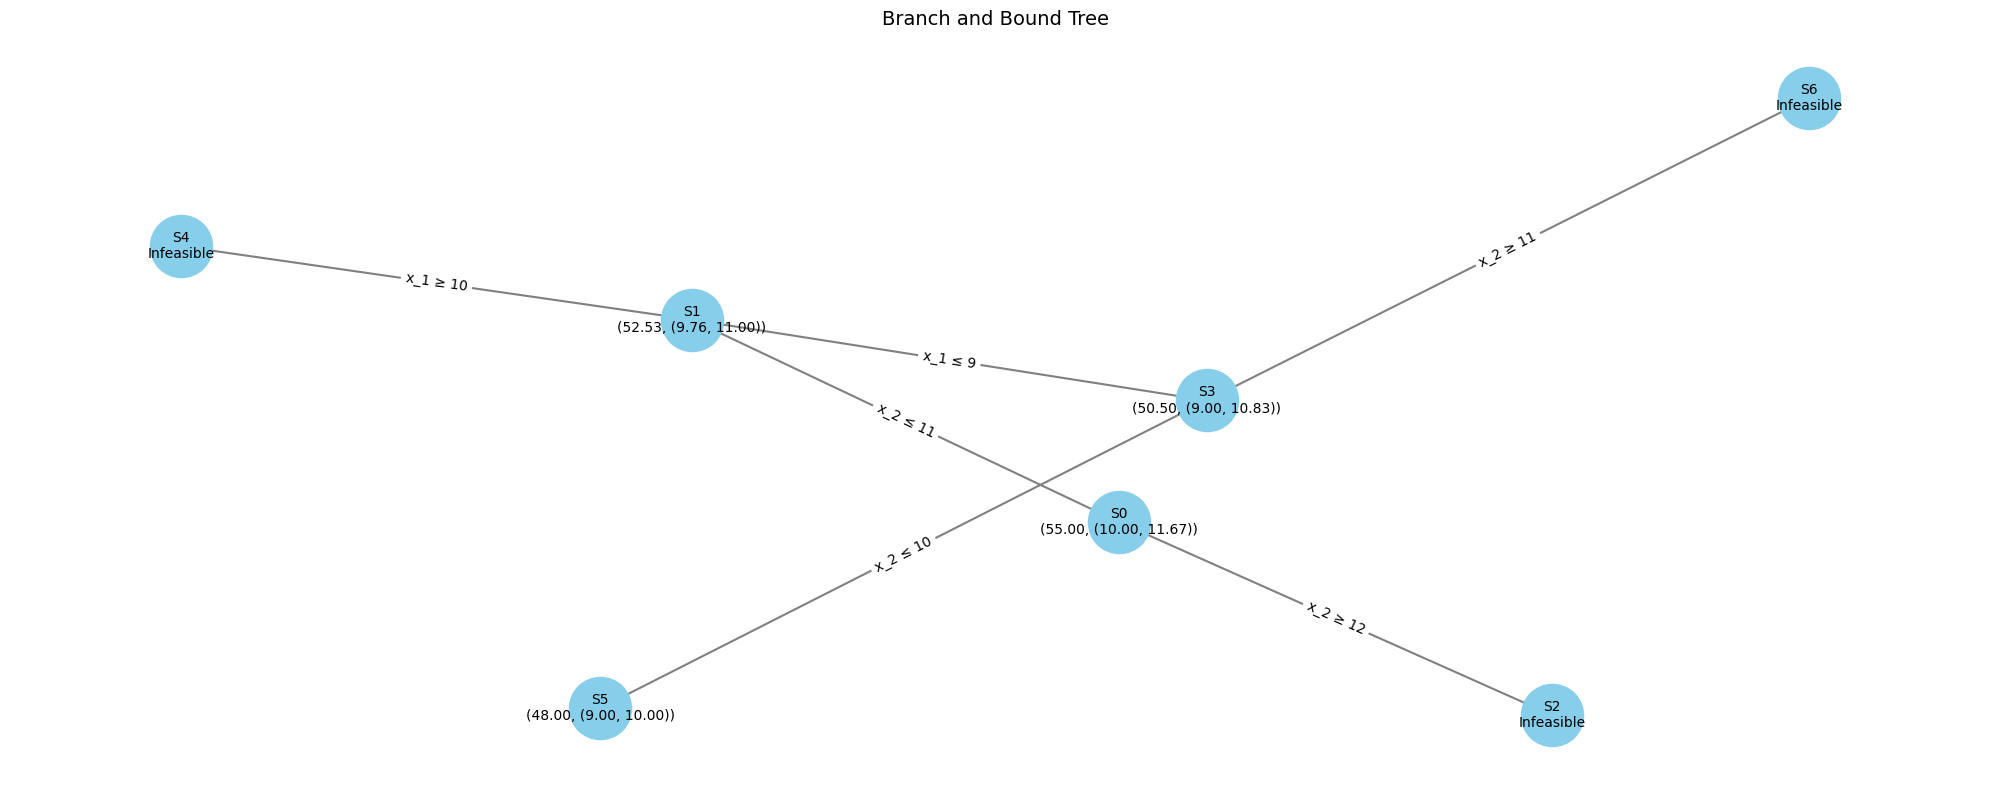


Validation with CVXPY's integer solver:
CVXPY integer optimizer objective: 48.0
CVXPY integer optimizer solution: x_1 = 9.0, x_2 = 10.0

Continuous solution for comparison:
Optimal continuous objective value: 54.99999994187286
Optimal continuous solution: x_1 = 10.000000, x_2 = 11.666667


In [100]:
# Example using the Branch and Bound solver on the provided problem
if __name__ == "__main__":
    # Problem definition:
    # max 5x_1 + x_2
    # subject to:
    #  -x_1 + 2x_2 <= 4.5
    #   x_1 - x_2 <= 1.5
    #   4x_1 + x_2 <= 12
    #   x_1, x_2 >= 0
    
    # Set up the problem data
    c = np.array([2, 3])  # Objective coefficients
    A = np.array([
        [17,-6],
        [-5,6],
       
    ])
    b = np.array([100,20])

    # use the matrix to display the problem
    print("\n--- Problem Matrix ---")
    print("Objective coefficients (c):")
    print(c)
    print("Constraint coefficients (A):")
    print(A)
    print("Right-hand side (b):")
    print(b)
    print("Variable bounds (x >= 0):")
    print("x_1, x_2 >= 0")
    
    # Create and run the solver
    solver = BranchAndBoundSolver(c, A, b, integer_vars=[0, 1], maximize=True)
    solution, objective = solver.solve(verbose=True)
    
    # Compare with CVXPY's integer solver (for validation)
    print("\nValidation with CVXPY's integer solver:")
    x = cp.Variable(2, integer=True)
    objective_fn = cp.Maximize(c @ x)
    constraints = [A @ x <= b, x >= 0]
    int_prob = cp.Problem(objective_fn, constraints)
    int_result = int_prob.solve()
    
    print(f"CVXPY integer optimizer objective: {int_result}")
    print(f"CVXPY integer optimizer solution: x_1 = {x.value[0]}, x_2 = {x.value[1]}")
    
    # Compare with continuous solution
    print("\nContinuous solution for comparison:")
    x_cont = cp.Variable(2)
    objective_cont = cp.Maximize(c @ x_cont)
    constraints_cont = [A @ x_cont <= b, x_cont >= 0]
    cont_prob = cp.Problem(objective_cont, constraints_cont)
    cont_result = cont_prob.solve()
    
    print(f"Optimal continuous objective value: {cont_result}")
    print(f"Optimal continuous solution: x_1 = {x_cont.value[0]:.6f}, x_2 = {x_cont.value[1]:.6f}")

Step 1: Solving root relaxation (continuous problem)
Root relaxation objective: 5.000000
Root solution: [1. 1.]
Root solution is integer-feasible! No need for branching.
+--------+-----+--------------+------+--------------+------+------+---------------------+
| Node   |   z | x            |   z* | x*           |   UB |   LB | Z at end of stage   |
+========+=====+==============+======+==============+======+======+=====================+
| S0     |   5 | (1.00, 1.00) |    5 | (1.00, 1.00) |    5 |    5 | ∅                   |
+--------+-----+--------------+------+--------------+------+------+---------------------+


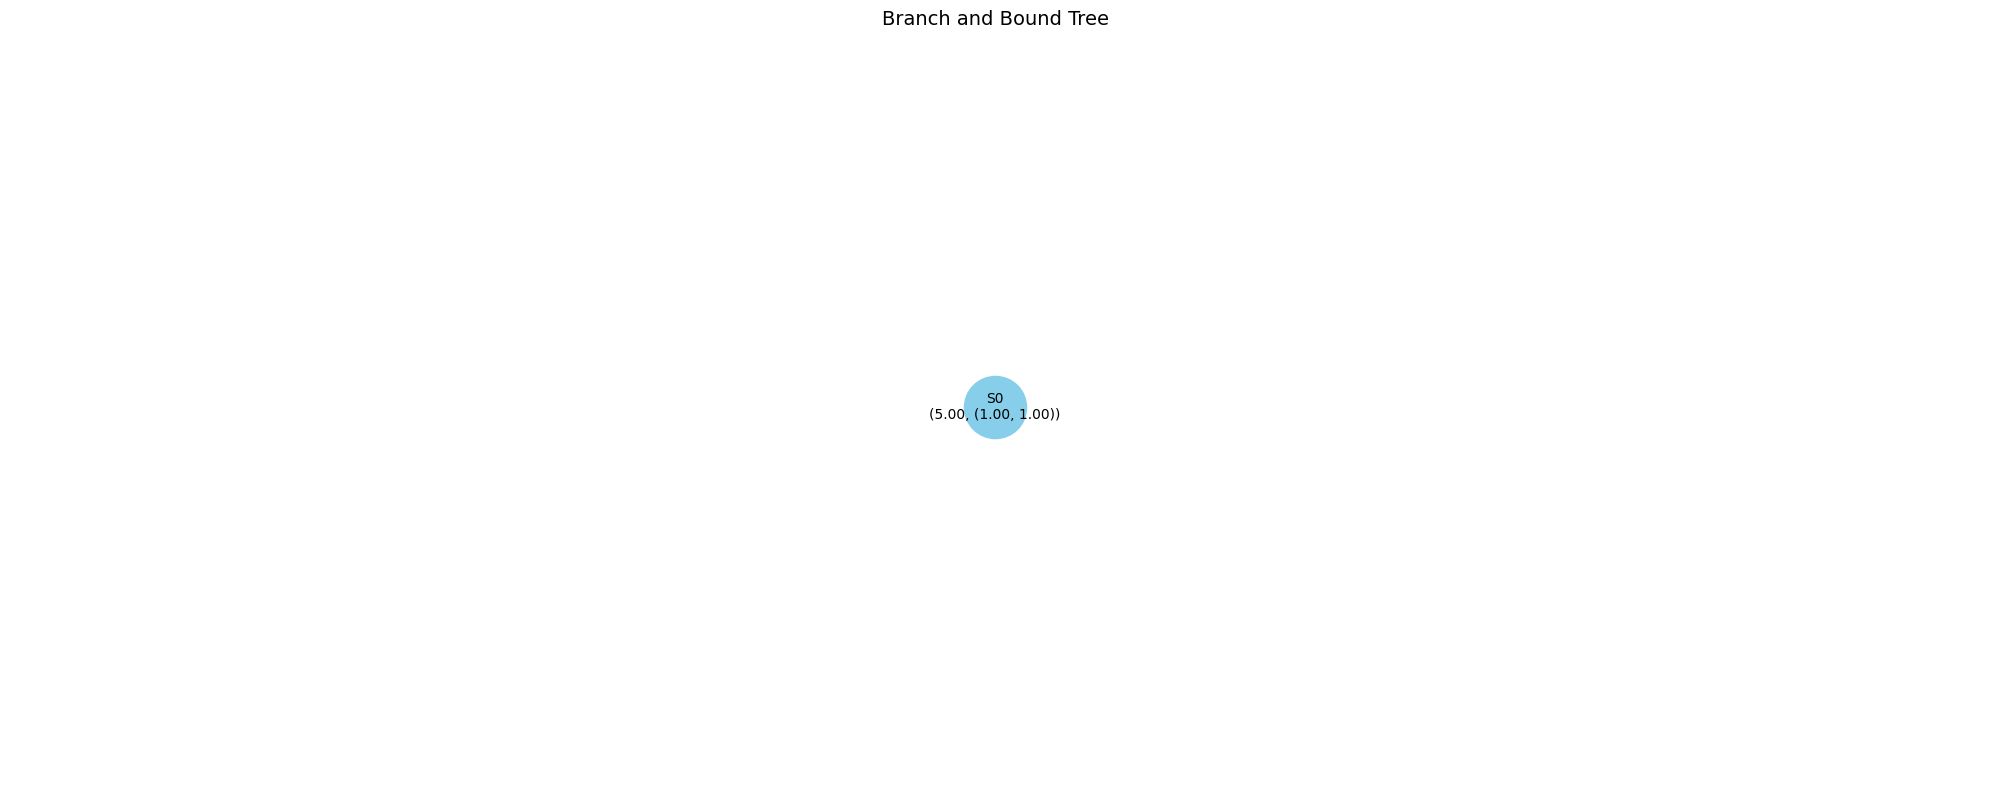


Validation with CVXPY's integer solver:


ValueError: Incompatible dimensions (1, 2) (4, 1)

In [99]:
# Example using the Branch and Bound solver on the provided problem
if __name__ == "__main__":
    # Set up the problem data
    c = np.array([2, 3])  # Objective coefficients
    A = np.array([
        [17,-6],
        [-5,6],
       
    ])
    b = np.array([100,20])

    # Create and run the solver
    solver = BranchAndBoundSolver(c, A, b, 
                                  binary_vars=[0, 1],  # Make all variables binary
                                  maximize=True
                                  )
    solution, objective = solver.solve(verbose=True)
    
    # Compare with CVXPY's integer solver (for validation)
    print("\nValidation with CVXPY's integer solver:")
    x = cp.Variable(4, boolean=True)  # Use 4 binary variables
    objective_fn = cp.Maximize(c @ x)
    constraints = [A @ x <= b]
    int_prob = cp.Problem(objective_fn, constraints)
    int_result = int_prob.solve()
    
    print(f"CVXPY integer optimizer objective: {int_result}")
    print(f"CVXPY integer optimizer solution: {x.value}")
    
    # Compare with continuous solution
    print("\nContinuous solution for comparison:")
    x_cont = cp.Variable(4)  # Use 4 variables
    objective_cont = cp.Maximize(c @ x_cont)
    constraints_cont = [A @ x_cont <= b, x_cont >= 0, x_cont <= 1]  # Box constraints
    cont_prob = cp.Problem(objective_cont, constraints_cont)
    cont_result = cont_prob.solve()
    
    print(f"Optimal continuous objective value: {cont_result}")
    print(f"Optimal continuous solution: {x_cont.value}")